In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

random_seed = 42

## Import Data

In [2]:
from sklearn.utils import shuffle

mcu = pd.read_csv("./data/mcu.csv")

min_line_count = 150

is_main_character = mcu["character"].value_counts() > min_line_count
is_main_character = is_main_character.rename("is main character", axis=0)

main_character_rows = is_main_character[mcu["character"]]
main_character_rows = main_character_rows.reset_index(drop=True)

mcu = mcu[main_character_rows]

y = mcu["character"].to_numpy().astype(str)
X = mcu["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=random_seed)

X, y

(array(['Got it.', 'And terrifying.', 'What’s the delta rate?', ...,
        'I’m sorry. He seemed like a good man.', 'Heimdall, come on.',
        'I am a king!'], dtype='<U606'),
 array(['BRUCE BANNER', 'PEPPER POTTS', 'TONY STARK', ..., 'STEVE ROGERS',
        'THOR', 'LOKI'], dtype='<U12'))

## Models

In [3]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics

import matplotlib.pyplot as plt

In [4]:
cross_validator = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
score_method = "balanced_accuracy"

Let's create two models: one that uses a TFIDF transformer and one that does not. 

### Model 1 (without TDIDF)

In [5]:
pipe1 = Pipeline([('vect', CountVectorizer()), 
                  ('clf', MultinomialNB())])

parameters1 = {'vect__binary': [True, False],
              'vect__stop_words': [None, 'english'],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

model1 = GridSearchCV(pipe1, parameters1, scoring=score_method, n_jobs=-1)

results = cross_validate(model1, X, y, cv=cross_validator, 
                         scoring=score_method, return_estimator=True)

table = pd.DataFrame({score_method: results['test_score']})
table.index.name = "fold"
table.loc["mean"] = table[score_method].mean()
table.loc["std"] = table[score_method].std()
table.loc["max"] = table[score_method].max()

table

,balanced_accuracy
fold,
0,0.271395
1,0.235389
2,0.237887
3,0.283962
4,0.259470
mean,0.257620
std,0.018819
max,0.283962


### Model 2 (with TDIDF)

In [6]:
pipe2 = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])

parameters2 = {'vect__binary': [True, False],
              'vect__stop_words': [None, 'english'],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False],
              'tfidf__smooth_idf': [True, False],
              'tfidf__sublinear_tf': [True, False],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

model2 = GridSearchCV(pipe2, parameters2, scoring=score_method, n_jobs=-1)

results = cross_validate(model2, X, y, cv=cross_validator, 
                         scoring=score_method, return_estimator=True)

table = pd.DataFrame({score_method: results['test_score']})
table.index.name = "fold"
table.loc["mean"] = table[score_method].mean()
table.loc["std"] = table[score_method].std()
table.loc["max"] = table[score_method].max()

table

,balanced_accuracy
fold,
0,0.258653
1,0.239661
2,0.250071
3,0.258814
4,0.250202
mean,0.251480
std,0.007050
max,0.258814


Looks like model 1 performed better.  Let's see it's confusion matrix on a random train / test split of the data in case there are any obvious patterns.

balanced_accuracy: 0.26168377566249235


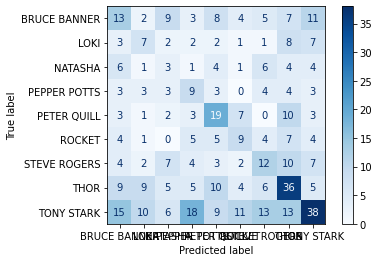

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model1.fit(X_train,y_train)
yhat = model1.predict(X_test)

print("balanced_accuracy:", metrics.balanced_accuracy_score(y_test, yhat))

plot = metrics.plot_confusion_matrix(model1, X_test, y_test,
                             values_format = 'd',
                             cmap=plt.cm.Blues)

## Learning Curve

Do we have enough training examples?  Let's find out.

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plot

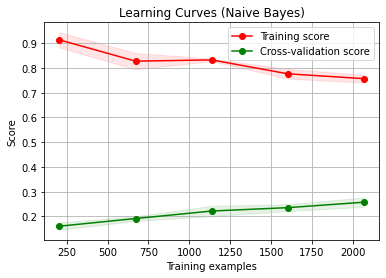

In [9]:
from sklearn.model_selection import learning_curve

title = "Learning Curves (Naive Bayes)"

plot_learning_curve(model1, title, X, y, cv=cross_validator)

## Conclusions

It appears to me that these scores in the learning curve have not converged, which suggests that more training examples might yield better performance on this model.  Also, the balanced accuracy shown in the tables above show very poor performance.  I'm willing to bet this could be because of how little data I have.  However, there is a chance that Naive Bayes just doesn't work well on this dataset.  In general, movie characters will be discussing similar topics (the plot of the movie), which might make it hard to distinguish character using a bag of words model like NB.

I'm going to try a different model first (most likely SVM or NN), and then, if needed, I'll add more movies to the dataset and retry Naive Bayes.